In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import sim
import util
import torch
from IPython.display import clear_output
from models import GibbsLDA, CollapsedGibbsLDA, PyroLDA

clear_output()

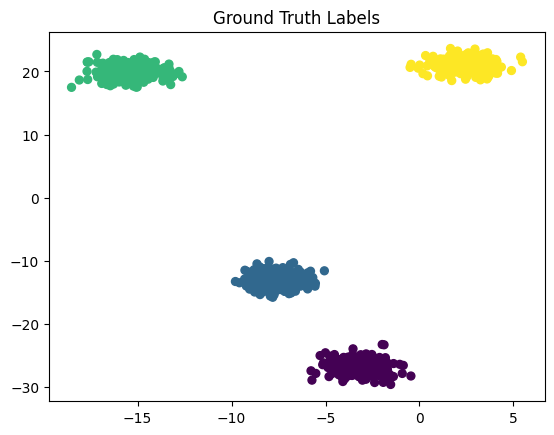

In [478]:
N_SAMPLES = 1000
N_FEATURES = 1000
N_TOPICS = 4
SCALE = 1
DISCRETIZE = False
SHUFFLE = True

if DISCRETIZE:
    X, X_labels, vocab = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
else:
    X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
util.visualize_data(X, X_labels, 'Ground Truth Labels')

In [479]:
X.shape

(1000, 1000)

In [480]:
from scipy.cluster.vq import kmeans, vq
from sklearn.neighbors import NearestNeighbors

In [481]:
neighbors = NearestNeighbors(n_neighbors=10).fit(X)

In [482]:
_, idx = neighbors.kneighbors(X)
idx

array([[  0, 321, 578, ..., 137, 292, 649],
       [  1, 966, 228, ..., 339, 199, 698],
       [  2, 152, 311, ..., 973, 309, 936],
       ...,
       [997, 829, 266, ..., 555, 209, 848],
       [998, 966, 476, ..., 641, 757, 414],
       [999, 835, 200, ..., 627, 718,   2]])

In [483]:
k = 25
iters = 100
codebook, variance = kmeans(X, k, iters)
codebook.shape

(25, 1000)

In [484]:
Y = np.zeros((X.shape[0], 10), dtype=np.int32)
for i in range(Y.shape[0]):
    Y[i], _ = vq(X[idx][i], codebook)
Y

array([[14, 18, 24, ..., 18, 18, 18],
       [16,  4,  6, ...,  6,  4,  6],
       [10,  9, 17, ...,  9, 17, 23],
       ...,
       [19, 12, 19, ..., 19, 19, 12],
       [20,  4, 20, ...,  8,  4,  8],
       [17, 17, 23, ..., 23, 21, 10]], dtype=int32)

In [497]:
values, _ = vq(X, codebook)
values

array([14, 16, 10,  9,  4, 19, 18, 10,  0,  5,  9,  1, 24,  6,  4, 17, 19,
        6, 19,  4, 19,  6, 24, 12,  1, 18, 23,  8, 24,  5, 12, 18,  2, 14,
       24, 18,  9, 19, 24, 23,  5, 18, 19, 18,  5,  8,  8,  3, 19, 10, 14,
       18, 10, 19, 19, 12,  2, 23, 19, 12,  2, 21, 19, 12, 18, 12, 18, 23,
       12, 16, 24,  8, 17, 18, 10,  5,  5, 10,  3, 19, 19,  6, 19,  9,  5,
       17, 14,  6, 19, 18,  3, 19,  8, 14, 12,  2, 12, 19,  9, 18,  6, 23,
       19,  4,  3, 23,  8, 12,  3, 23,  9,  4, 18, 19,  9, 17, 19, 12,  6,
        0, 14, 19, 12, 12, 19, 23, 23,  3,  3, 18, 19,  9, 12, 24, 14, 19,
        6, 18,  8,  1,  1, 14, 24, 18, 14, 18, 22, 12, 10, 22,  6,  9,  9,
        5,  1, 19, 20, 24, 15, 19, 24, 18, 20, 18,  5, 23,  8, 23,  2, 19,
       12, 10,  7,  3, 14,  4, 17, 18, 18,  4, 19,  1, 12,  8,  6,  6, 16,
       12, 19,  5,  6,  4, 16, 19,  6, 21, 24, 23, 24,  4, 23, 19, 17,  9,
        9,  6,  4, 15, 14, 19, 24, 18,  4,  9, 18,  6, 24,  9,  6, 18, 19,
       16,  4,  4,  4, 10

In [576]:
Z = np.concatenate([X[:, :2], values[None].T], -1)
Z

array([[  1.20305472,  20.76460361,  14.        ],
       [ -6.88274022, -12.71896411,  16.        ],
       [-15.47125528,  19.84169159,  10.        ],
       ...,
       [ -2.70470254, -27.90114158,  19.        ],
       [ -8.23323986, -11.33096804,  20.        ],
       [-15.98424624,  18.43142407,  17.        ]])

In [577]:
N_DOCS = 150
doc_idx = np.random.permutation(Z.shape[0])[:N_DOCS]
doc_locs = Z[doc_idx, :2]
doc_locs

array([[-16.07576839,  21.26201762],
       [ -3.65772642, -26.95550164],
       [  1.59579612,  22.46231217],
       [ -6.07308855, -13.28209282],
       [ -3.61238601, -27.37679832],
       [ -4.10358395, -25.53923267],
       [ -7.14326671, -14.01714804],
       [-16.46669462,  20.72905333],
       [ -6.2050639 , -13.73232647],
       [-16.45259185,  21.27807315],
       [  2.91918373,  21.25962582],
       [ -7.98427951, -13.17385784],
       [-14.76644297,  19.72407434],
       [ -3.40923022, -27.3537301 ],
       [-14.69701659,  20.08404896],
       [ -3.55142151, -27.70110642],
       [ -4.25285739, -25.65477015],
       [  1.67762325,  19.95294312],
       [-14.68948985,  21.04006226],
       [-15.05454147,  20.98811741],
       [-15.81711673,  18.63374269],
       [ -3.7965856 , -26.33040557],
       [ -7.14735362, -14.07037157],
       [-13.86973466,  20.38009342],
       [ -2.5103648 , -27.24152931],
       [ -7.3714773 , -14.03142424],
       [ -3.67877022, -27.97034273],
 

In [ ]:
topic_assignments = np.random.choice(N_TOPICS, X.shape[0])
Z = np.concatenate([Z, topic_assignments[None].T], -1)
Z  # (x, y, value, doc, topic)

In [578]:
# doc_assignments = np.random.choice(doc_locs.shape[0], X.shape[0])
doc_assignments = np.zeros(X.shape[0], dtype=np.int32)
for i in range(doc_assignments.shape[0]):
    doc_assignments[i] = sample_doc(Z[i, 0], Z[i, 1], topic_assignments[i])
Z = np.concatenate([Z, doc_assignments[None].T, topic_assignments[None].T], -1)
Z

array([[  1.20305472,  20.76460361,  14.        ,  89.        ,
          2.        ],
       [ -6.88274022, -12.71896411,  16.        , 104.        ,
          2.        ],
       [-15.47125528,  19.84169159,  10.        ,  33.        ,
          1.        ],
       ...,
       [ -2.70470254, -27.90114158,  19.        ,  67.        ,
          2.        ],
       [ -8.23323986, -11.33096804,  20.        , 104.        ,
          1.        ],
       [-15.98424624,  18.43142407,  17.        ,  56.        ,
          3.        ]])

In [579]:
topic_word_counts = np.zeros((N_TOPICS, 25), dtype=np.int32)
for i in range(N_TOPICS):
    idx, counts = np.unique(Z[Z[:, -1] == i, -3], return_counts=True)
    topic_word_counts[i, idx.astype(np.int32)] = counts
topic_word_counts

array([[ 0,  3,  2,  3, 26,  6, 14,  1, 10, 16, 16,  1, 21,  0, 16,  2,
         4, 10, 28, 34,  5,  5,  4, 21, 16],
       [ 0,  5,  6,  1, 17,  5, 11,  0, 11, 12, 19,  0, 13,  0, 12,  1,
         4,  5, 24, 37,  2,  8,  0, 25, 14],
       [ 3,  1,  2,  8, 17, 13, 23,  0, 12, 19,  7,  0, 20,  0, 14,  2,
         3,  5, 28, 31,  3,  3,  1, 16, 12],
       [ 1,  5,  8,  4, 13,  5, 24,  0, 15, 15, 13,  2, 18,  1, 12,  0,
         6,  7, 26, 36,  4,  6,  3, 22, 15]], dtype=int32)

In [580]:
doc_topic_counts = np.zeros((150, N_TOPICS), dtype=np.int32)
for i in range(150):
    idx, counts = np.unique(Z[Z[:, -2] == i, -1], return_counts=True)
    doc_topic_counts[i, idx.astype(np.int32)] = counts
doc_topic_counts

array([[ 7,  5,  0,  1],
       [ 5,  3,  4,  4],
       [ 0,  0,  0,  0],
       [ 5,  1,  1,  1],
       [ 2,  2,  2,  1],
       [ 0,  1,  0,  2],
       [ 0,  0,  2,  2],
       [ 1,  0,  0,  2],
       [ 1,  0,  2,  2],
       [ 0,  1,  1,  1],
       [ 2,  1,  1,  0],
       [ 0,  2,  3,  2],
       [ 2,  0,  0,  2],
       [ 2,  3,  3,  2],
       [ 1,  3,  1,  1],
       [ 1,  1,  0,  0],
       [ 2,  6,  0,  4],
       [ 2,  1,  1,  2],
       [ 1,  6,  0,  0],
       [ 2,  0,  2,  1],
       [ 4,  1,  2,  1],
       [11,  4,  2,  1],
       [ 5,  1,  2,  3],
       [ 2,  2,  0,  2],
       [ 1,  1,  1,  3],
       [ 0,  3,  1,  1],
       [ 1,  1,  1,  0],
       [ 1,  4,  2,  2],
       [ 1,  1,  3,  2],
       [ 1,  0,  1,  1],
       [ 1,  0,  1,  3],
       [ 1,  1,  1,  2],
       [ 0,  2,  0,  3],
       [ 2,  3,  2,  1],
       [ 3,  2,  3,  5],
       [ 0,  1,  2,  4],
       [ 0,  0,  0,  1],
       [ 1,  0,  0,  2],
       [18,  1,  3,  2],
       [ 1,  1,  3,  5],


In [581]:
from tqdm import tqdm

100%|██████████| 1000/1000 [00:23<00:00, 42.95it/s]

Score: 0.389


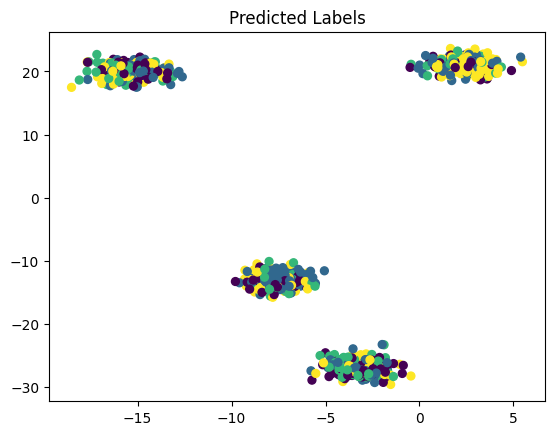

In [582]:
N_STEPS = 1000
SIGMA = 1

likelihood_log = []

def sample_doc(word_x, word_y, old_topic):
    probs = np.exp(-((word_x - doc_locs[:, 0])**2 + (word_y - doc_locs[:, 1])**2)/SIGMA**2)*(doc_topic_counts[:, old_topic] + 1/N_TOPICS)/(doc_topic_counts[:, old_topic] + 1/N_TOPICS).sum()
    probs /= probs.sum()
    return np.random.choice(probs.shape[0], p=probs)

def sample_topic(word_value, old_doc):
    topic_word_dist = topic_word_counts[:, word_value]/topic_word_counts.sum(-1)
    doc_topic_dist = doc_topic_counts[old_doc]/doc_topic_counts[old_doc].sum()
    probs = topic_word_dist*doc_topic_dist
    probs /= probs.sum()
    topic = np.random.choice(probs.shape[0], p=probs)
    likelihood_log[-1] += probs[topic]
    return topic

for _ in tqdm(range(N_STEPS)):
    likelihood_log.append(0.)
    for i in range(Z.shape[0]):
        (word_x, word_y), (word_value, old_doc, old_topic) = Z[i, :2], Z[i, -3:].astype(np.int32)
        if topic_word_counts[old_topic, word_value] < 2 or doc_topic_counts[old_doc, old_topic] < 2:
            continue
        doc_topic_counts[old_doc, old_topic] -= 1
        topic_word_counts[old_topic, word_value] -= 1
        new_doc = sample_doc(word_x, word_y, old_topic)
        new_topic = sample_topic(word_value, old_doc)
        Z[i, -2], Z[i, -1] = new_doc, new_topic
        doc_topic_counts[new_doc, new_topic] += 1
        topic_word_counts[new_topic, word_value] += 1

Y_labels, score = util.evaluate(X_labels, Z[:, -1])
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

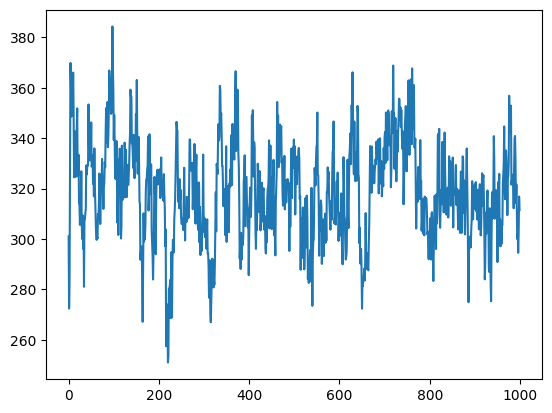

In [583]:
y = likelihood_log
x = np.arange(len(y))
plt.plot(x, y);

100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


Score: 0.902


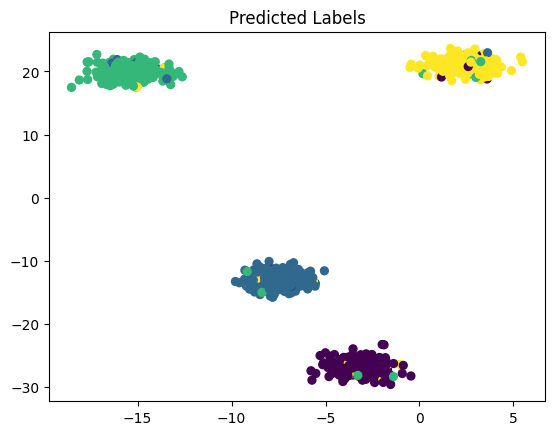

In [492]:
N_STEPS = 100

model = GibbsLDA(N_TOPICS).fit(Y, N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

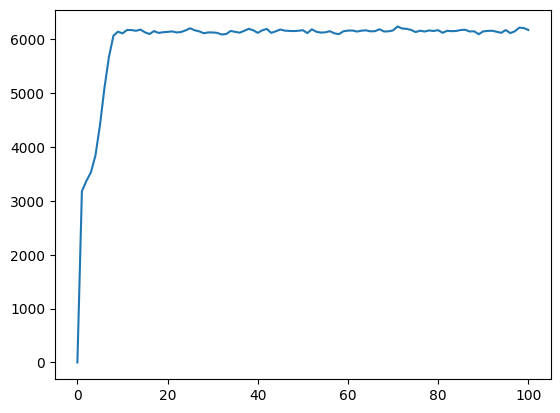

In [493]:
y = model.likelihood_log_
# y = model.loss_log_
x = np.arange(len(y))
plt.plot(x, y);

100%|██████████| 50/50 [00:08<00:00,  6.16it/s]


Score: 0.987


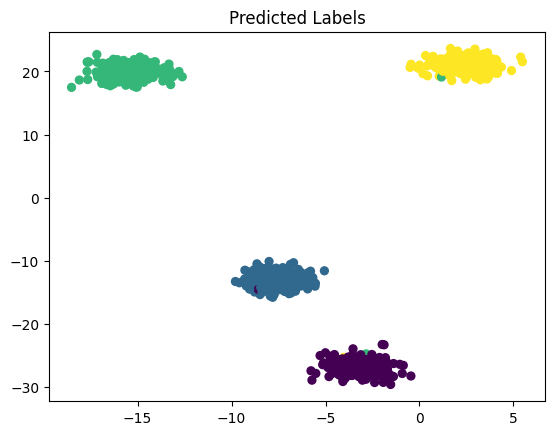

In [487]:
N_STEPS = 50

model = CollapsedGibbsLDA(N_TOPICS).fit(Y, N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

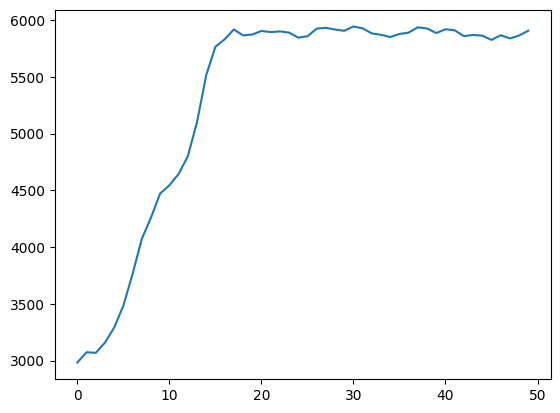

In [488]:
y = model.likelihood_log_
x = np.arange(len(y))
plt.plot(x, y);

100%|██████████| 1000/1000 [00:02<00:00, 353.09it/s]

Score: 1.0


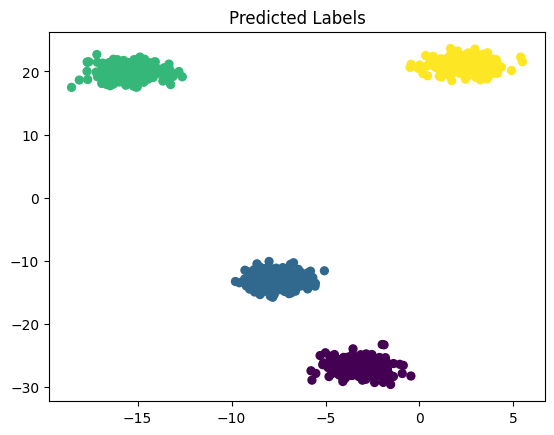

In [489]:
N_STEPS = 1000

pyro.clear_param_store()
Z = torch.tensor(Y).T
model = PyroLDA(N_TOPICS, batch_size=100).fit(Z, N_STEPS, 1e-1)
Y_labels, score = util.evaluate(X_labels, model.transform(Z))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

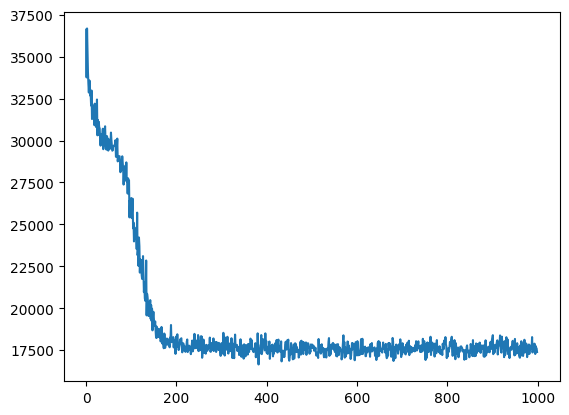

In [490]:
y = model.loss_log_
x = np.arange(len(y))
plt.plot(x, y);